In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os.path as path

import lib.dist as dist
import lib.utils as utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600,
    'savefig.bbox' : 'tight'
})
torch.__version__

'1.7.1'

In [2]:
b = 60

txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-2.10.dat')
s_num, s_len = txt.shape
print("txt.shape =", s_num, s_len)
s_train = 1000
s_test = 1000
if (s_train+s_test > s_num): print("WARNING : not enough datapoints")


U = np.array([0.01*i for i in range(100, 401)])
U_up, U_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../1_QMC/train/Bethe_14_beta{b:d}/field-{u:.2f}.dat')==True: U_up.append(u)
    if path.isfile(f'../1_QMC/train/Bethe_41_beta{b:d}/field-{u:.2f}.dat')==True: U_dn.append(u)
U_up = np.array(U_up)
U_dn = np.array(U_dn)
spin2d_up_train = np.zeros((len(U_up)*s_train, s_len))
spin2d_dn_train = np.zeros((len(U_dn)*s_train, s_len))
spin2d_up_test = np.zeros((len(U_up)*s_test, s_len))
spin2d_dn_test = np.zeros((len(U_dn)*s_test, s_len))
print("U_up, U_dn len =", len(U_up), len(U_dn))
print("spin2d_up_train size =", spin2d_up_train.shape[0], spin2d_up_train.shape[1])
print("spin2d_dn_train size =", spin2d_dn_train.shape[0], spin2d_dn_train.shape[1])

for i, u in enumerate(U_up):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-{u:.2f}.dat')
    spin2d_up_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_up_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]
for i, u in enumerate(U_dn):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/field-{u:.2f}.dat')
    spin2d_dn_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_dn_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]

latent_dim = 4
beta = 4
prior_dist = dist.Normal()
q_dist = dist.Normal()

spin2d = np.concatenate([spin2d_up_train, spin2d_dn_train])
spin2d = torch.Tensor(spin2d)
print("spin2d size =", spin2d.size())

txt.shape = 3000 288
U_up, U_dn len = 33 40
spin2d_up_train size = 33000 288
spin2d_dn_train size = 40000 288
spin2d size = torch.Size([73000, 288])


In [9]:
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(CEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, 128) # 8
        self.L2 = nn.Linear(128, 32) # 4
        self.L3 = n.Linear(32, output_dim)

        # setup the non-linearity
        self.act = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        h = x.view(-1, s_len)
        h = self.act(self.L1(h))
        h = self.act(self.L2(h))
        z = (self.L3(h)).view(x.size(0), self.output_dim)
        return self
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(CDecoder, self).__init__()
        self.L1 = nn.Linear(128, s_len) # 8
        self.L2 = nn.Linear(32, 128) # 4
        self.L3 = nn.Linear(input_dim, 32)

        # setup the non-linearity
        self.act = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        h = self.act(self.L3(h))
        h = self.act(self.L2(h))
        mu_img = self.act(self.L1(h))
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
def display_samples(model, x):
    fig, ax = plt.subplots(2,1, figsize = (13, 2))
    th = 1
    sample_mu = model.model_sample(batch_size=50).sigmoid()
    xs, x_params, zs, z_params = model.reconstruct_img(x)
    ax[0].imshow(x, aspect='auto')
    ax[1].imshow(xs, aspect='auto')
    #ax[2].imshow(x_params[th,0].detach().numpy())
    #ax[3].imshow(z_params[:,:,0].detach().numpy())
    #ax[4].imshow(z_params[:,:,1].detach().numpy())
    plt.show()

In [10]:
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()


In [11]:
model = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model.load_state_dict(torch.load('./frozen/VAE_NN_1.pth'))

<All keys matched successfully>

dataset_size, num_iter = 69000 3500
[n = 000] ELBO = -199.626389 (-199.929686)


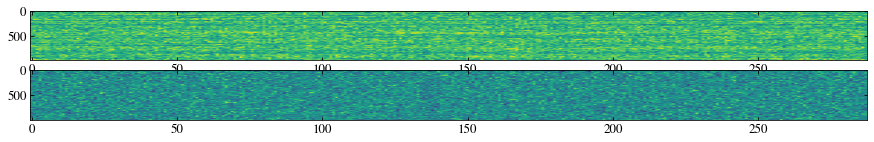

[n = 050] ELBO = -199.626389 (-199.626374)


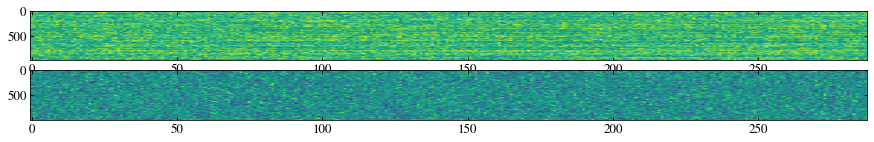

[n = 100] ELBO = -199.626389 (-199.626374)


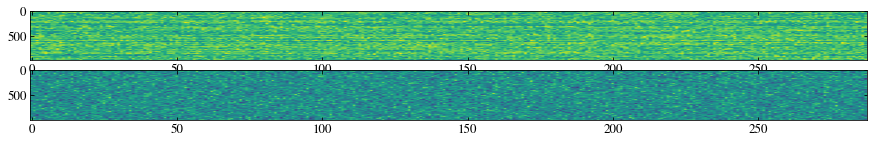

[n = 150] ELBO = -199.626389 (-199.626374)


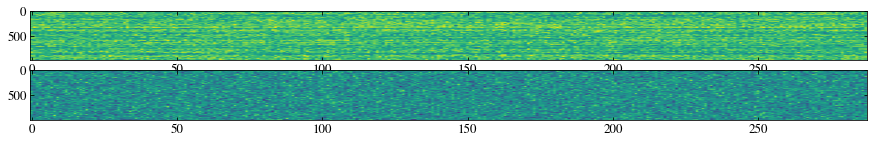

[n = 200] ELBO = -199.626389 (-199.626374)


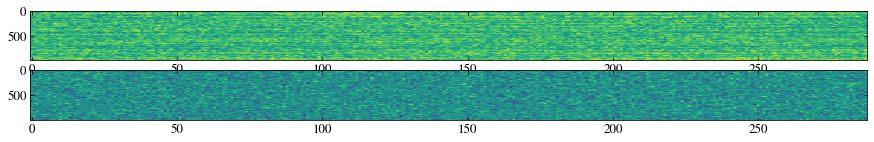

[n = 250] ELBO = -199.626389 (-199.626374)


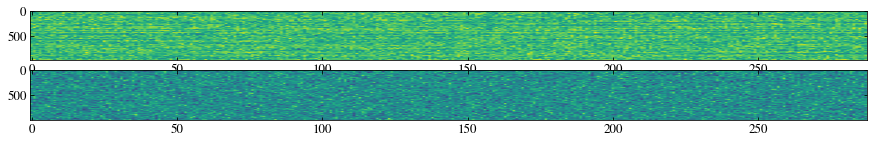

[n = 300] ELBO = -199.626389 (-199.626374)


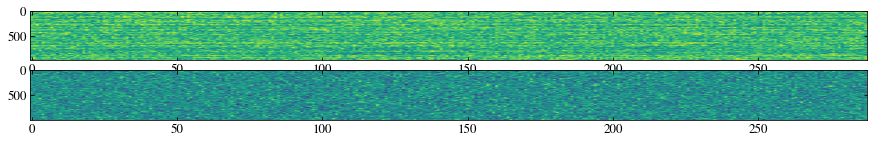

[n = 350] ELBO = -199.626389 (-199.626374)


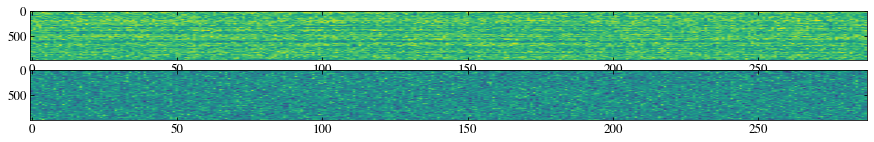

[n = 400] ELBO = -199.626389 (-199.626374)


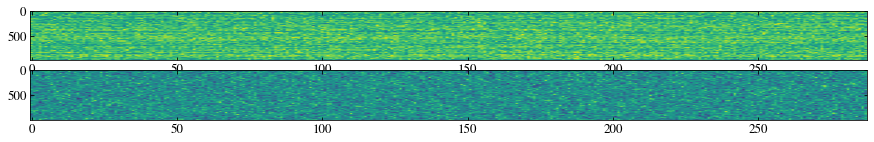

[n = 450] ELBO = -199.626389 (-199.626374)


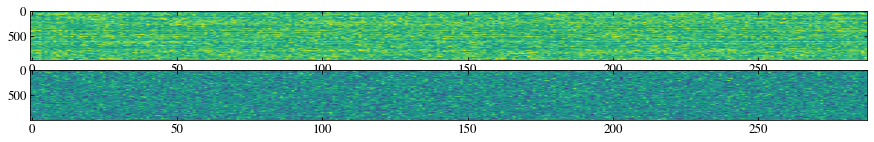

[n = 500] ELBO = -199.626389 (-199.626374)


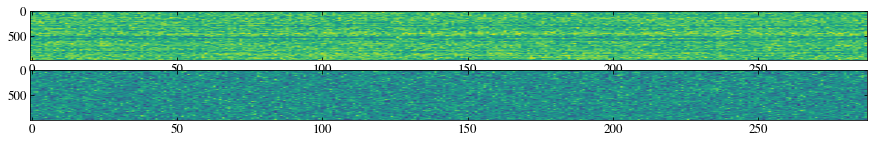

[n = 550] ELBO = -199.626389 (-199.626374)


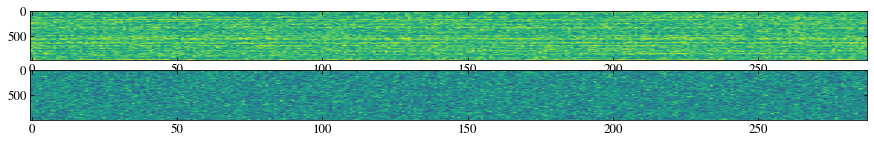

[n = 600] ELBO = -199.626389 (-199.626374)


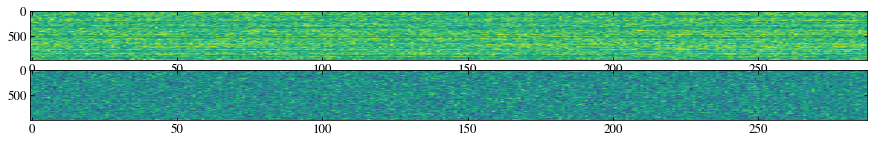

[n = 650] ELBO = -199.626389 (-199.626374)


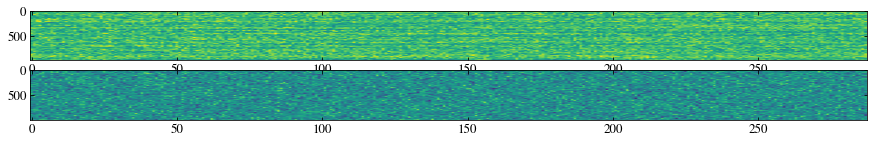

[n = 700] ELBO = -199.626389 (-199.626374)


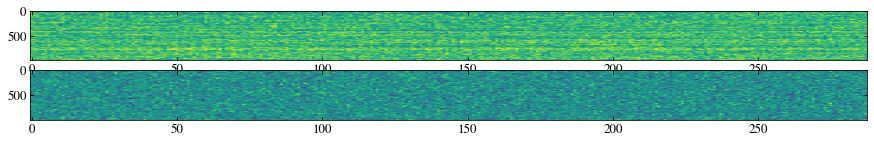

[n = 750] ELBO = -199.626389 (-199.626374)


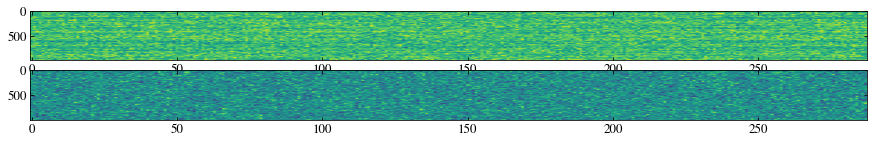

[n = 800] ELBO = -199.626389 (-199.626374)


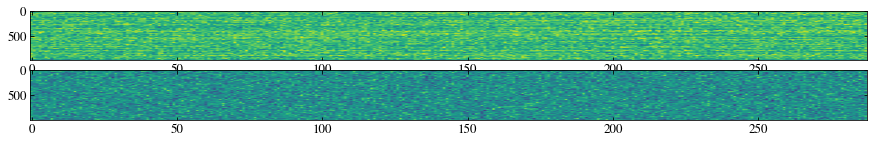

[n = 850] ELBO = -199.626389 (-199.626374)


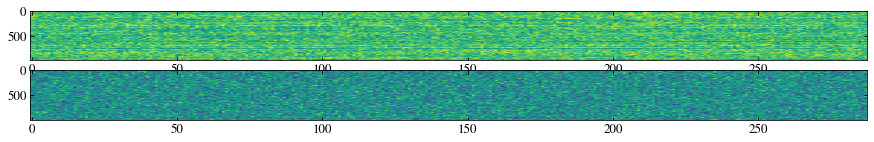

[n = 900] ELBO = -199.626389 (-199.626374)


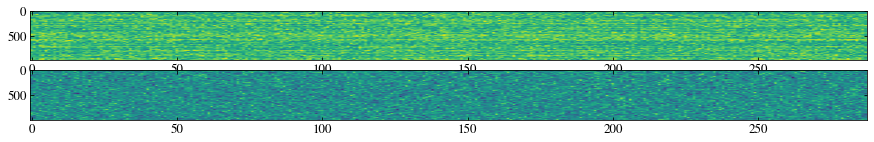

[n = 950] ELBO = -199.626389 (-199.626374)


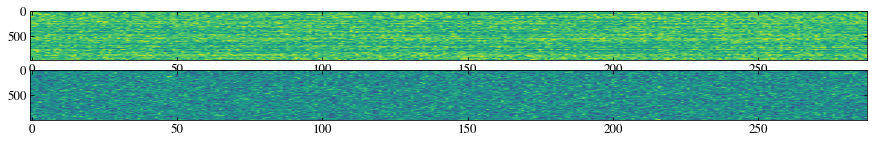

[n = 1000] ELBO = -199.626389 (-199.626374)


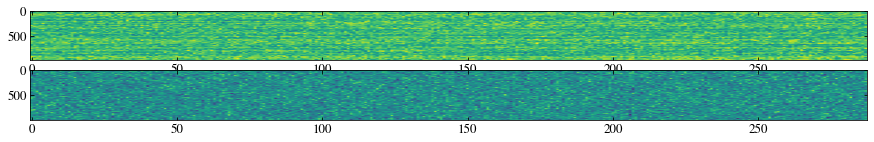

[n = 1050] ELBO = -199.626389 (-199.626374)


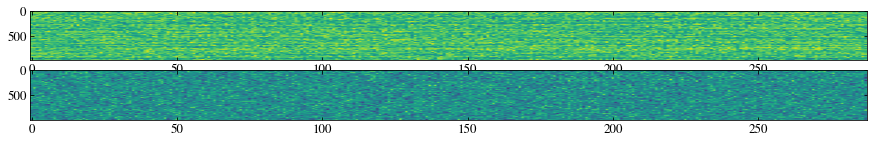

[n = 1100] ELBO = -199.626389 (-199.626374)


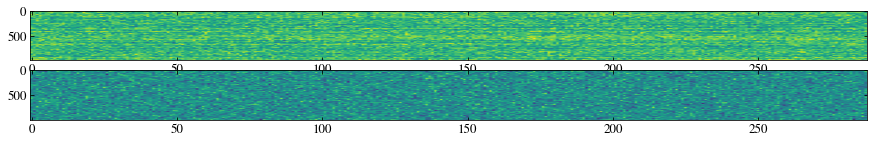

[n = 1150] ELBO = -199.626389 (-199.626374)


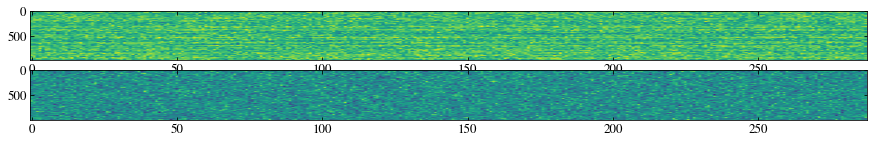

[n = 1200] ELBO = -199.626389 (-199.626374)


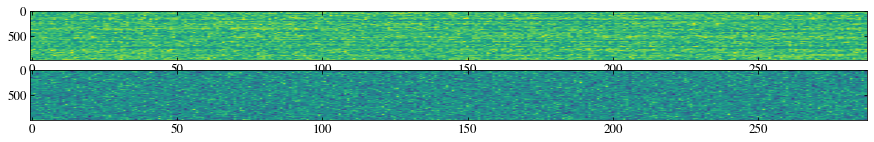

[n = 1250] ELBO = -199.626389 (-199.626374)


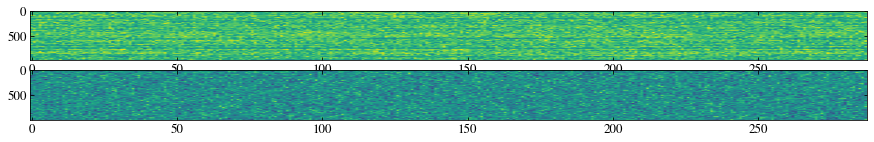

[n = 1300] ELBO = -199.626389 (-199.626374)


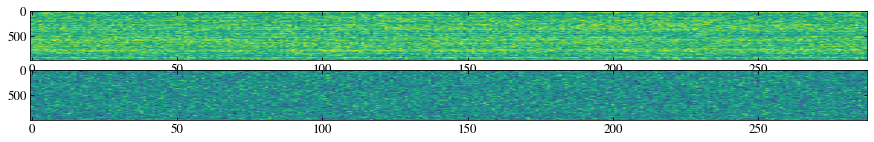

[n = 1350] ELBO = -199.626389 (-199.626374)


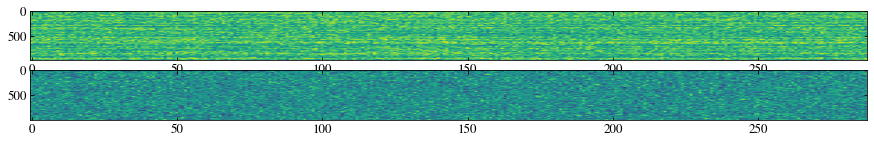

[n = 1400] ELBO = -199.626389 (-199.626374)


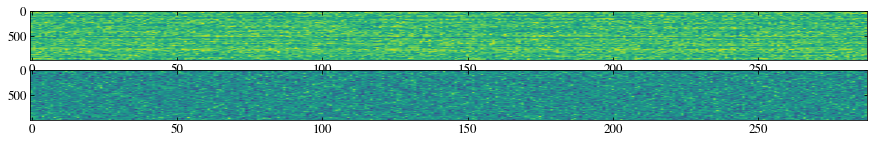

[n = 1450] ELBO = -199.626389 (-199.626374)


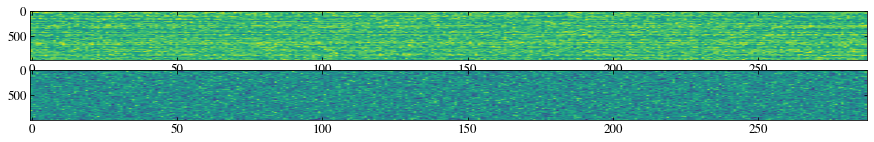

[n = 1500] ELBO = -199.626389 (-199.626374)


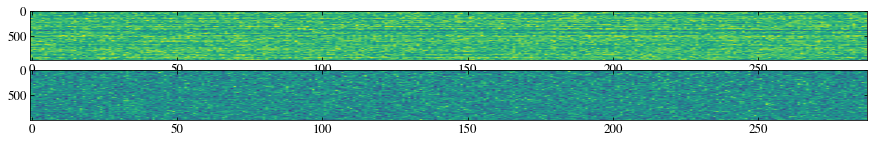

[n = 1550] ELBO = -199.626389 (-199.626374)


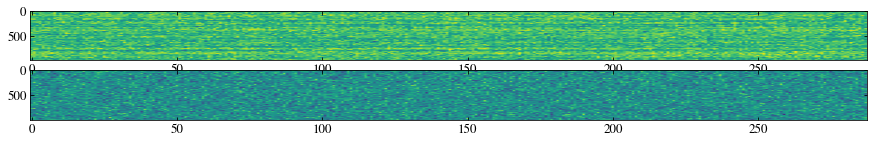

[n = 1600] ELBO = -199.626389 (-199.626374)


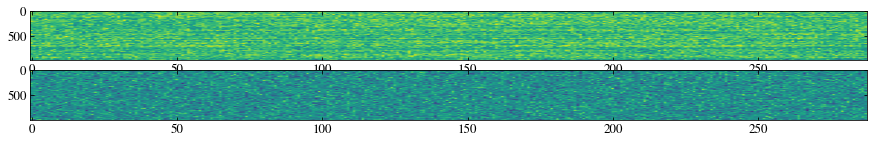

[n = 1650] ELBO = -199.626389 (-199.626374)


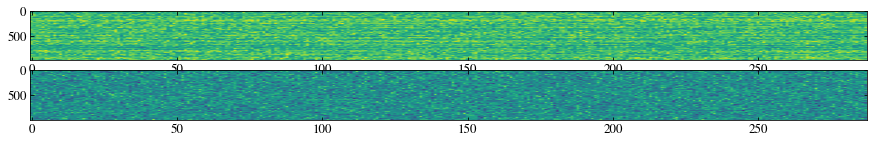

[n = 1700] ELBO = -199.626389 (-199.626374)


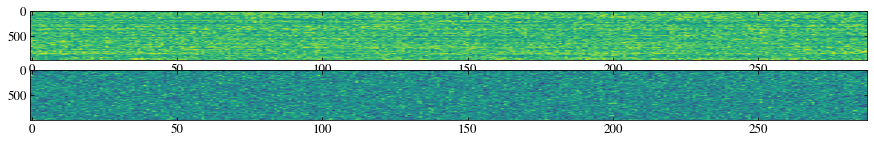

KeyboardInterrupt: 

In [58]:
model = TCVAE(z_dim = latent_dim, beta = beta, prior_dist = prior_dist, q_dist = q_dist)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(dataset = spin2d, batch_size = 1000, shuffle = True)

train_elbo = []
dataset_size = len(train_loader.dataset)
num_iter = len(train_loader)*100
elbo_run_mean = utils.RunningAverageMeter()

print("dataset_size, num_iter =", dataset_size, num_iter)

for n in range(num_iter):
    for i,x in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        obj, elbo = model.elbo(x, dataset_size)
        if utils.isnan(obj).any(): break
        obj.mean().mul(-1).backward()
        elbo_run_mean.update(elbo.mean().item())
        optimizer.step()
        
    if n%50==0:
        train_elbo.append(elbo_run_mean.avg)
        print('[n = %03d] ELBO = %.6f (%.6f)'%(n, elbo_run_mean.val, elbo_run_mean.avg))
        display_samples(model, x)

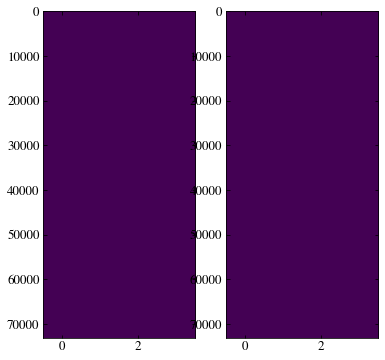

In [28]:
spin2dtest = np.concatenate([spin2d_up_test, spin2d_dn_test])
spin2dtest = torch.Tensor(spin2dtest)
xs, x_params, zs, z_params = model.reconstruct_img(spin2dtest)

test_mu = z_params[:, :, 0].detach().numpy()
test_logsig = z_params[:, :, 1].detach().numpy()
test_var = np.exp(test_logsig * 2)
fig, ax = plt.subplots(1,2, figsize = (6, 6))
ax[0].imshow(test_mu, aspect = 'auto')
ax[1].imshow(test_var, aspect = 'auto')

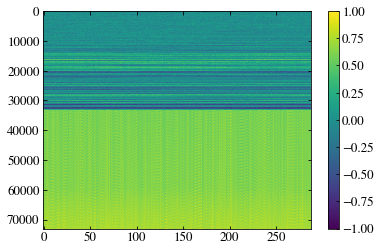

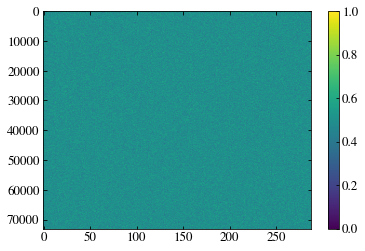

In [29]:
plt.imshow(spin2dtest.reshape(73000, 288), aspect='auto')
cd = plt.colorbar()
plt.show()

plt.imshow(xs.reshape(73000, 288), aspect='auto')
cd = plt.colorbar()
plt.show()

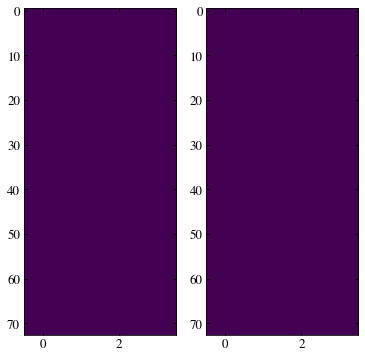

In [30]:
test_ens_mu = np.zeros((73, 4))
test_ens_logsig = np.zeros((73, 4))
for i in range(73):
    test_ens_mu[i] = np.average(z_params[i*1000:(i+1)*1000, :, 0].detach().numpy(), axis=0)
    test_ens_logsig[i] = np.average(z_params[i*1000:(i+1)*1000, :, 1].detach().numpy(), axis=0)
test_ens_var = np.exp(test_ens_logsig * 2)
fig, ax = plt.subplots(1,2, figsize = (6, 6))
ax[0].imshow(test_ens_mu, aspect = 'auto')
ax[1].imshow(test_ens_var, aspect = 'auto')

In [119]:
torch.save(model.state_dict(), 'frozen/VAE_NN_1.pth')

# PCA

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [329]:
pca2.explained_variance_

array([8.97965419e-04, 1.74442410e-05, 5.30592151e-07])

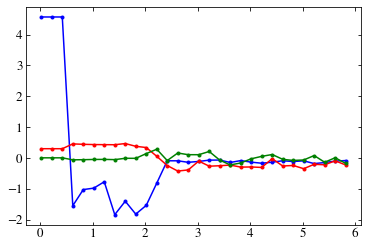

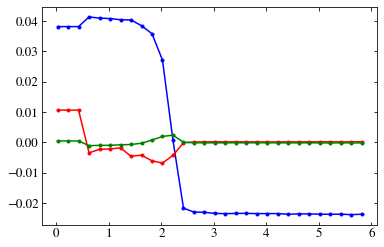

In [328]:
#scaler1 = StandardScaler()
#scaler1.fit(test_mu)
#mu_scaled = scaler1.transform(test_mu)
pca1 = PCA(n_components=3)
pca1.fit(test_ens_mu)
mu_pca = pca1.transform(test_ens_mu)

#scaler2 = StandardScaler()
#scaler2.fit(test_var)
#var_scaled = scaler2.transform(test_var)
pca2 = PCA(n_components=3)
pca2.fit(test_ens_var)
var_pca = pca2.transform(test_ens_var)

T = np.arange(30)*0.2+0.02
TT = np.repeat(T, 1)

plt.plot(TT, mu_pca[:,0], 'b.-')
plt.plot(TT, mu_pca[:,1], 'r.-')
plt.plot(TT, mu_pca[:,2], 'g.-')
plt.show()

plt.plot(TT, var_pca[:,0], 'b.-')
plt.plot(TT, var_pca[:,1], 'r.-')
plt.plot(TT, var_pca[:,2], 'g.-')
plt.show()

In [60]:
"""### VAE
cCh=16
ksize=7
fD=cCh*2*20*20
zD=16
class VAE(nn.Module):
    def __init__(self, imgCh=1): # 7: 32-26-20, 5: 32-28-24
        super().__init__()
    
        self.eC1 = nn.Conv2d(imgCh, cCh, kernel_size = ksize)
        self.eC2 = nn.Conv2d(cCh, cCh*2, kernel_size = ksize)
        self.eL1 = nn.Linear(fD, zD) 
        self.eL2 = nn.Linear(fD, zD)
    
        self.dL1 = nn.Linear(zD, fD)
        self.dC1 = nn.ConvTranspose2d(cCh*2, cCh, ksize)
        self.dC2 = nn.ConvTranspose2d(cCh, imgCh, ksize)
    
        self.actv = nn.SELU()
        self.Sigm = torch.Sigmoid()
    
    def encoder(self, x):
        x = self.actv(self.eC1(x))
        x = self.actv(self.eC2(x))
        x = x.view(-1, fD)
        mu = self.eL1(x)
        logvar = self.eL2(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        x = self.actv(self.dL1(z))
        x = x.view(-1, cCh*2, 20, 20)
        x = self.actv(self.dC1(x))
        x = self.Sigm(self.dC2(x))
        return x
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar"""

In [49]:
L1 = nn.Linear(288, 1024) # 8
L2 = nn.Linear(1024, 256) # 4
L3 = nn.Linear(256, 64)
L4 = nn.Linear(64, 8)
act = nn.ReLU()

h = spin2d
h = act(L1(h))
print(h.shape)
h = act(L2(h))
print(h.shape)
h = act(L3(h))
print(h.shape)
z = L4(h).view(spin2d.size(0), 8)
zp = z.view(spin2d.size(0), 4, 2)
zs = dist.Normal().sample(params=zp)
print(z.shape, zp.shape, zs.shape)


L1 = nn.Linear(1024, 288) # 8
L2 = nn.Linear(256, 1024) # 4
L3 = nn.Linear(64, 256)
L4 = nn.Linear(4, 64)


h = zs
h = act(L4(h))
h = act(L3(h))
h = act(L2(h))
mu_img = act(L1(h))
mu_img.shape

torch.Size([69000, 1024])
torch.Size([69000, 256])
torch.Size([69000, 64])
torch.Size([69000, 8]) torch.Size([69000, 4, 2]) torch.Size([69000, 4])


torch.Size([69000, 288])